# SST: Analysis for Item Test

###Procedure

**Session 1**: 

1. Watch 4 videos of each town (2/town in a row)
2. <span style="color:red"> Item test (run 1)</span>
3. Navigation with arrows (2/town)
4. <span style="color:red">Item test (run 2)</span>

**Session 2**:

1. Watch 1 video of each town (2 for subjects 1-4)
2. <span style="color:red">Item test (run 3)</span>
3. Navigation with arrows (2/town)
4. Free navigation without arrows (2/town)
5. <span style="color:red">Item test (run 4)</span>

**Session 3**:

1. Test trials, navigate to item in each environment (2 cycles)
2. Questionnaire about strategies used, etc.
3. <span style="color:red">Item test (run 5)</span>
4. Map drawing
5. Spatial preference questionnaire

### Item test: 
Present subjects with image from town, and asked to recall the 3 items located within that town and to type the names of the items. If they didn't remember an item, they responded with a "?".


Sample image from town:

![env3](./images/env3.jpg)


## Import packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as op
import numpy as np

# for plotting
sns.set(style='whitegrid', context='poster')
%matplotlib inline

# R for stats
# %load_ext rpy2.ipython
# %R require(lme4)
# %R require(lmerTest)

/Users/sgagnon/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/sgagnon/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Define color palette

In [2]:
palette = {'face': 'orange',
           'animal': 'dodgerblue',
           'object': 'lightseagreen',
           'food':  'mediumseagreen',
           'fruitveg':  'mediumseagreen',
           'tool': 'mediumpurple'}

## Setup paths

In [3]:
dirs = dict()
dirs['basedir'] = op.join(op.expanduser('~'), 'Experiments/SST')
dirs['datadir'] = op.join(dirs['basedir'], 'data')
dirs['analydir'] = op.join(dirs['basedir'], 'analysis')
dirs['subj_info_file'] = op.join(dirs['datadir'], 'subj_info.csv')
dirs['object_cat_file'] = op.join(dirs['datadir'], 'object_cat.csv')

In [13]:
subj_info = pd.read_csv(dirs['subj_info_file'])
subj_info = subj_info[pd.isnull(subj_info.remove)]
subj_info[['subid']] = subj_info.subid.astype(str)

subj_info

,subid,group,remove
2,3,control,NaN
3,4,control,NaN
4,5,control,NaN
5,6,control,NaN
6,7,control,NaN
7,9,control,NaN
8,10,control,NaN
9,11,control,NaN
10,12,control,NaN
11,13,control,NaN


In [14]:
#Load in file w/object sub-categories for each town, convert to dict
obj_cat = pd.read_csv(dirs['object_cat_file'])
obj_cat = obj_cat.set_index('town').to_dict()['object_cat']

## Load in data

In [15]:
dt = pd.DataFrame() 
test = True
questionnaires_post = True

for subid in subj_info.subid:
    print subid

    if test:
        # add test file
        test_file = op.join(dirs['datadir'], subid, subid + '_behav_itemTest_coded.csv')
        d2 = pd.read_csv(test_file)
        d2['subid'] = subid
        dt = dt.append(d2, ignore_index=True)
        
# Compiled group data
if questionnaires_post:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_group.csv')
    dq_post = pd.read_csv(q_file, index_col=0)
    dq_post['subid'] = dq_post.subid.astype(str)

3
4
5
6
7
9
10
11
12
13
14
15
18
19
20
21
22
23
24
26
29
30


In [16]:
dt.head()

,index,run,trial,onset,duration,town,pic,itemNum,resp,respRT,itemType,acc,subid
0,13,1,5,160.4599,17.2015,Town1,env1,1,?,15.8422,face,0,3
1,14,1,5,160.4599,17.2015,Town1,env1,2,?,0.6871,animal,0,3
2,15,1,5,160.4599,17.2015,Town1,env1,3,?,0.6704,fruitveg,0,3
3,70,2,12,446.5390,57.3189,Town1,env1,1,?,55.9022,face,0,3
4,71,2,12,446.5390,57.3189,Town1,env1,2,?,0.7028,animal,0,3


In [23]:
dt = dt.merge(subj_info)

#### Add in sub-type for objects

In [24]:
dt['itemType_sub'] = dt.itemType
dt.ix[dt.itemType == 'object', 'itemType_sub'] = dt[dt.itemType == 'object'].town.map(obj_cat.get)
dt.head()

,index,run,trial,onset,duration,town,pic,itemNum,resp,respRT,itemType,acc,subid,itemType_sub,group,remove
0,13,1,5,160.4599,17.2015,Town1,env1,1,?,15.8422,face,0,3,face,control,NaN
1,14,1,5,160.4599,17.2015,Town1,env1,2,?,0.6871,animal,0,3,animal,control,NaN
2,15,1,5,160.4599,17.2015,Town1,env1,3,?,0.6704,fruitveg,0,3,fruitveg,control,NaN
3,70,2,12,446.5390,57.3189,Town1,env1,1,?,55.9022,face,0,3,face,control,NaN
4,71,2,12,446.5390,57.3189,Town1,env1,2,?,0.7028,animal,0,3,animal,control,NaN


In [25]:
dq_post.head()

,subid,compass,generalSOD,landmark,route,survey,surveySpatial,verbalSpatial,survey_pref
0,10,12,21,6,7,10,3,3,4
1,11,4,11,8,8,5,4,3,-3
2,12,8,16,8,6,5,4,4,-3
3,13,10,17,8,8,4,2,4,-4
4,14,3,17,8,5,7,5,3,-1


## Analysis

In [41]:
data = dt.groupby(['subid', 'group']).mean().reset_index()
data.groupby(['group']).count()

,subid,index,run,trial,onset,duration,itemNum,respRT,acc,remove
group,,,,,,,,,,
control,16,16,16,16,16,16,16,16,16,0
stress,6,6,6,6,6,6,6,6,6,0


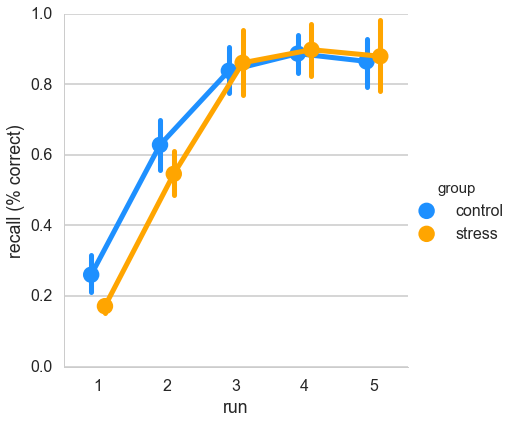

In [42]:
data = dt.groupby(['subid', 'group', 'run']).mean().reset_index()
data['recall (% correct)'] = data.acc
sns.factorplot(x='run', y='recall (% correct)', 
               dodge=.2, hue='group',
               units='subid', ci=68, data=data,
               palette = ['dodgerblue', 'orange'], size=6)
plt.ylim(0,1)
plt.savefig('/Volumes/group/awagner/sgagnon/SST/analysis/behav/bygroup_itemtest_acc.png')

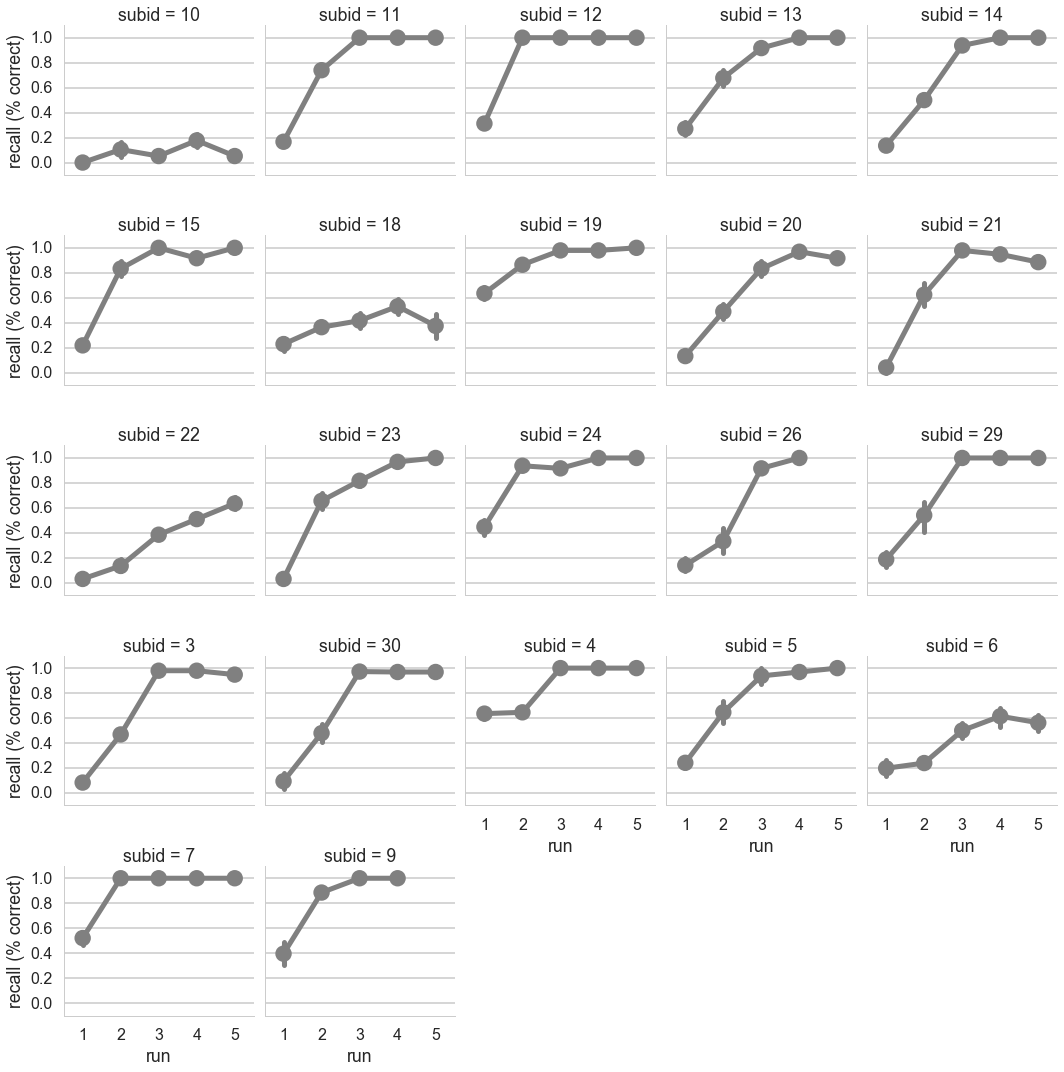

In [45]:
data = dt.groupby(['subid', 'run', 'itemType_sub']).mean().reset_index()
data['recall (% correct)'] = data.acc
sns.factorplot(x='run', y='recall (% correct)', 
               dodge=.1, ci=68,
               col='subid', col_wrap=5, data=data,
               color='gray', size=3)
plt.ylim(-.1,1.1)

plt.savefig('/Volumes/group/awagner/sgagnon/SST/analysis/behav/bysub_itemtest_acc.png')

### Accuracy across runs, by type of item

In [42]:
palette

{'animal': 'dodgerblue',
 'face': 'orange',
 'food': 'mediumseagreen',
 'fruitveg': 'mediumseagreen',
 'object': 'lightseagreen',
 'tool': 'mediumpurple'}

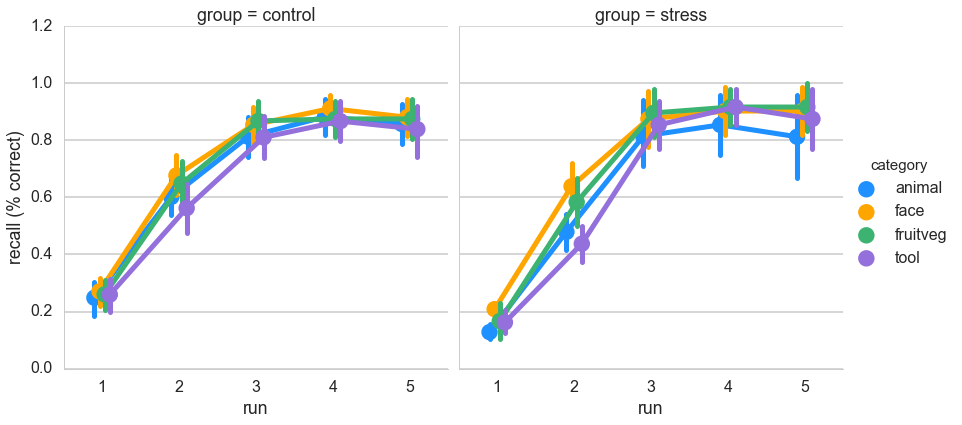

In [44]:
data = dt.groupby(['subid', 'group', 'run', 'itemType_sub']).mean().reset_index()
data['category'] = data.itemType_sub
data['recall (% correct)'] = data.acc
sns.factorplot(x='run', y='recall (% correct)', hue='category',
               dodge=.2, col='group',
               units='subid', ci=68, data=data,
               palette=palette, size=6)
# plt.title()
plt.savefig('/Volumes/group/awagner/sgagnon/SST/analysis/behav/group_itemtest_acc.png')

#### Mean accuracy and standard error for final training (4th) run

In [46]:
data = dt[dt.run == 4].groupby(['itemType_sub']).mean().reset_index()[['itemType_sub', 'acc']]
data['st.err'] = dt[dt.run == 4].groupby(['itemType_sub']).std().reset_index()[['acc']]/subj_info.subid.size
data

,itemType_sub,acc,st.err
0,animal,0.875000,0.015076
1,face,0.909091,0.013092
2,fruitveg,0.886364,0.014467
3,tool,0.880682,0.014777


In [47]:
data = dt[dt.run == 4].groupby('subid').mean().reset_index()
data.describe()

,index,run,trial,onset,duration,itemNum,respRT,acc,remove
count,22.0,22,22.0,22.000000,22.000000,22,22.000000,22.000000,0
mean,126.5,4,6.5,79.243658,14.030922,2,4.676300,0.890152,NaN
std,0.0,0,0.0,26.493672,4.039819,0,1.346608,0.215418,NaN
min,126.5,4,6.5,50.400625,8.788700,2,2.928903,0.194444,NaN
25%,126.5,4,6.5,62.688081,11.565450,2,3.854484,0.951389,NaN
50%,126.5,4,6.5,68.320404,13.031700,2,4.343226,0.972222,NaN
75%,126.5,4,6.5,88.248775,15.274179,2,5.090731,1.000000,NaN
max,126.5,4,6.5,168.246600,26.432742,2,8.810244,1.000000,NaN


#### Broken down by subject

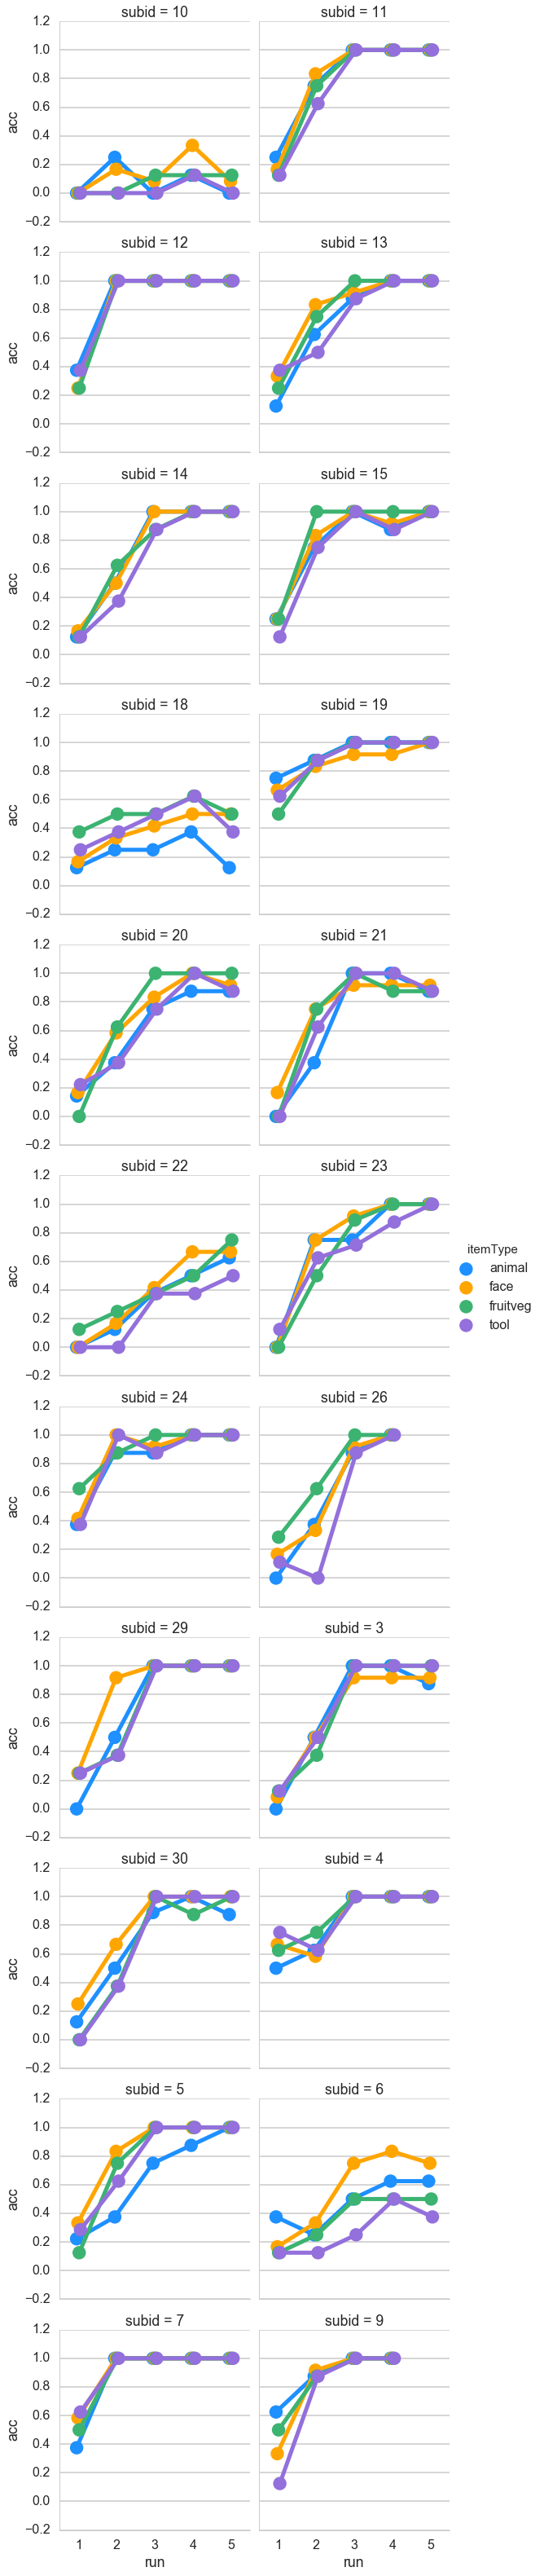

In [48]:
data = dt.groupby(['subid', 'run', 'itemType']).mean().reset_index()
sns.factorplot(x='run', y='acc', hue='itemType',
               dodge=.1,
               col='subid', col_wrap=2, data=data,
               palette=palette)

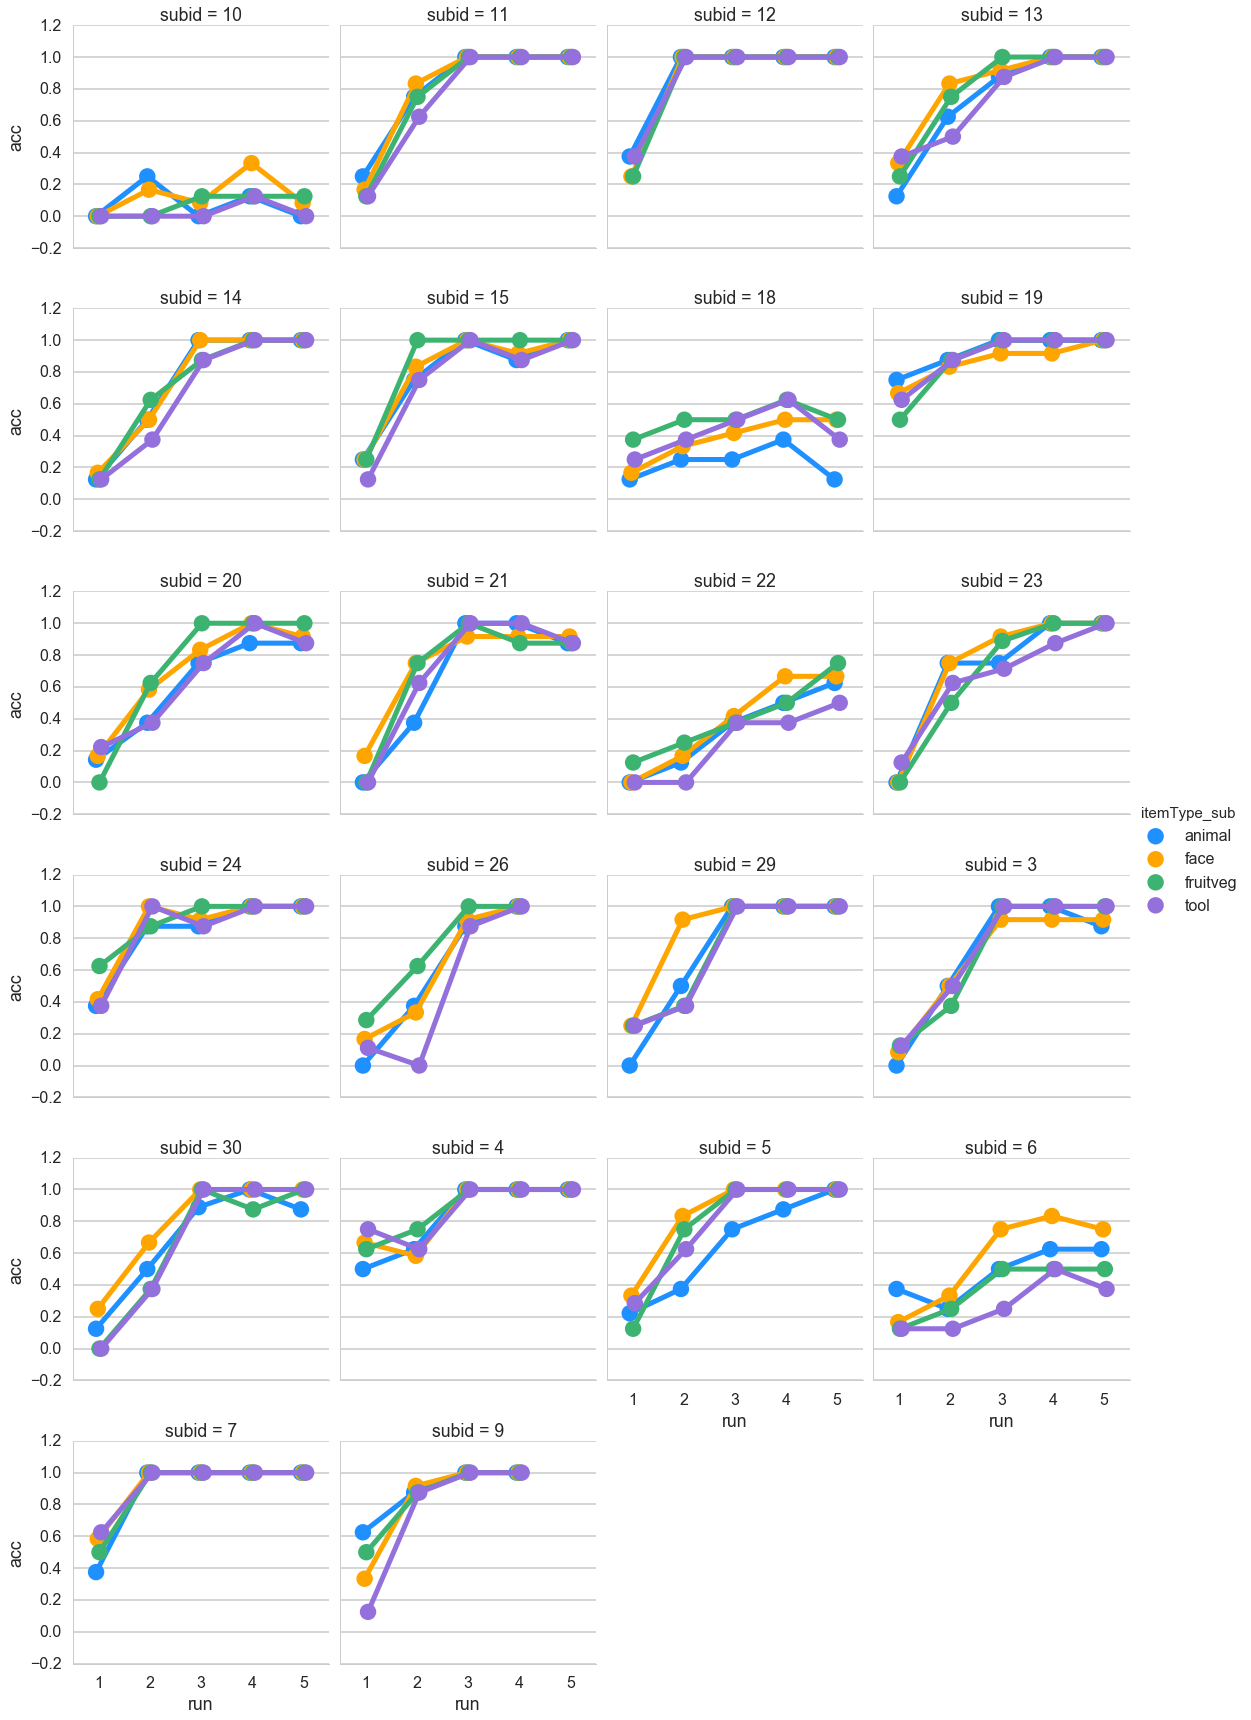

In [49]:
data = dt.groupby(['subid', 'run', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='run', y='acc', hue='itemType_sub',
               dodge=.1,
               col='subid', col_wrap=4, data=data,
               palette=palette)

### Final training accuracy for item types

In [50]:
data = dt[dt.run == 4].groupby(['subid']).mean().reset_index()
data[data.subid.isin(['1', '2', '3', '4', '7', '8'])].describe()

,index,run,trial,onset,duration,itemNum,respRT,acc,remove
count,3.0,3,3.0,3.000000,3.000000,3,3.000000,3.000000,0
mean,126.5,4,6.5,77.399317,14.072047,2,4.690009,0.990741,NaN
std,0.0,0,0.0,12.912973,1.527906,0,0.509302,0.016038,NaN
min,126.5,4,6.5,67.280400,12.470608,2,4.156206,0.972222,NaN
25%,126.5,4,6.5,70.127475,13.351125,2,4.449696,0.986111,NaN
50%,126.5,4,6.5,72.974550,14.231642,2,4.743186,1.000000,NaN
75%,126.5,4,6.5,82.458775,14.872767,2,4.956911,1.000000,NaN
max,126.5,4,6.5,91.943000,15.513892,2,5.170636,1.000000,NaN


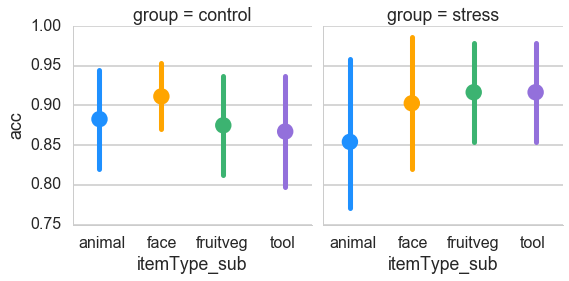

In [54]:
data = dt[dt.run == 4].groupby(['subid', 'group', 'run', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='itemType_sub', y='acc', hue='itemType_sub',
               dodge=.1, col='group',
               units='subid', ci=68, data=data, palette=palette)

plt.savefig('/Volumes/group/awagner/sgagnon/SST/analysis/behav/group_itemtest_acc_run4.png')

### How does final training accuracy relate to spatial preference?

In [55]:
data = dt[dt.run == 4].groupby(['subid']).mean().reset_index()
data = data.merge(dq_post, on='subid')

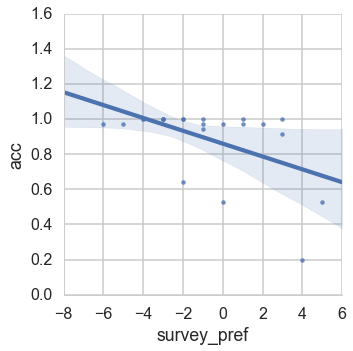

In [56]:
sns.lmplot(x='survey_pref', y='acc', 
           data=data)

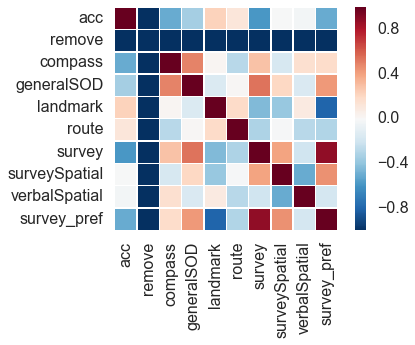

In [57]:
data = dt[dt.run == 4].groupby(['subid']).mean().reset_index()
data = data.merge(dq_post, on='subid')
dsub = data.ix[:,8:].T

sns.heatmap(np.corrcoef(dsub), 
            xticklabels=dsub.index,
            yticklabels=dsub.index,
            square=True)

#### Statistical difference between acc for different item types?

In [58]:
data = dt[dt.run == 4].groupby(['itemType_sub', 'subid', 'town']).mean().reset_index()[['subid', 'itemType_sub', 'acc', 'town']]
%R -i data

ERROR: Line magic function `%R` not found.


In [33]:
%%R

res1 = lmer(acc ~ itemType_sub + (1 | subid) + (1 | town), data=data)
res2 = lmer(acc ~ itemType_sub + (1 | subid), data=data)
print(anova(res2, res1, refit=FALSE))

print(summary(res1))

ERROR: Cell magic `%%R` not found.


### Final training (run 4) accuracy across environments

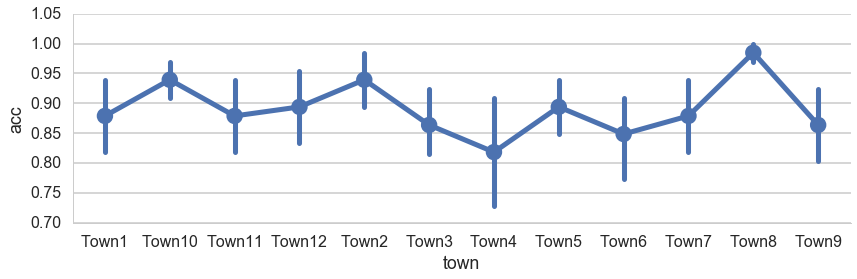

In [59]:
data = dt[dt.run == 4].groupby(['subid', 'run', 'town']).mean().reset_index()
sns.factorplot(x='town', y='acc', 
               dodge=.1, aspect=3,
               units='subid', ci=68, data=data)

#### Broken down by item type for each town

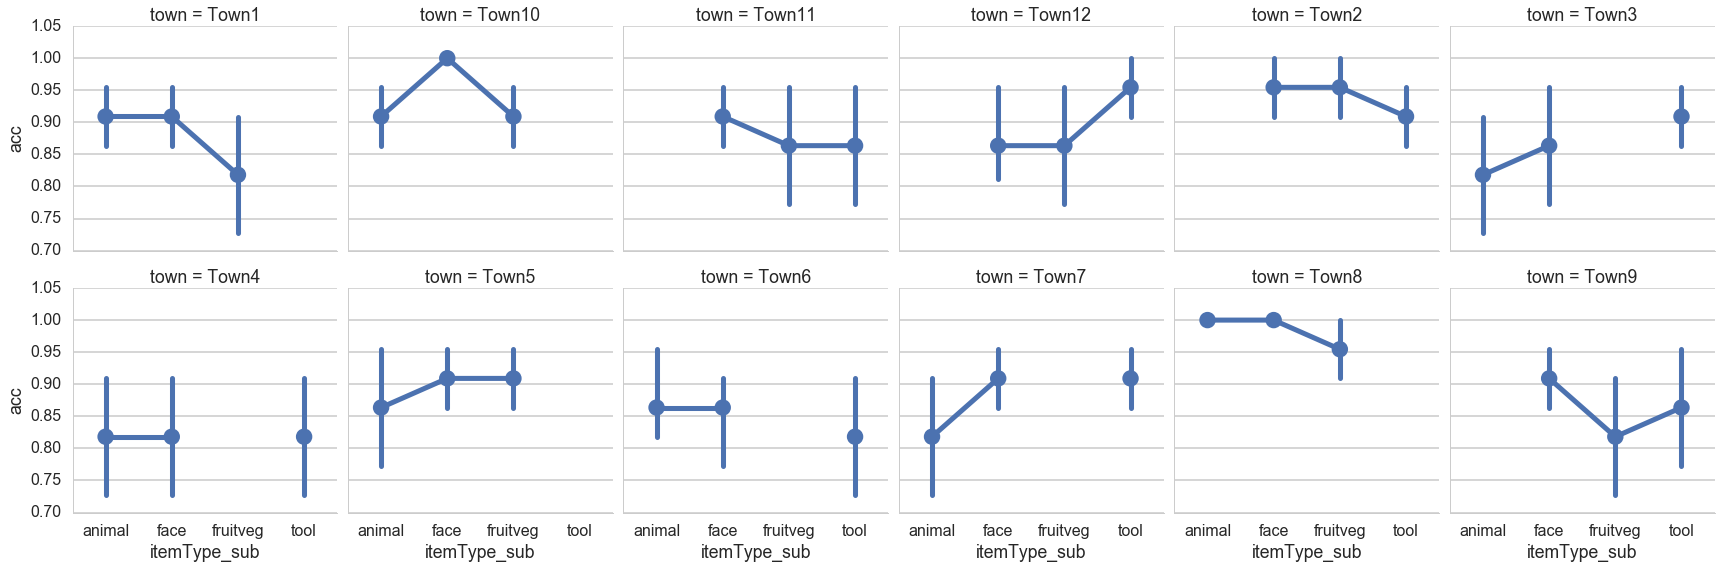

In [60]:
data = dt[dt.run == 4].groupby(['subid', 'run', 'town', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='itemType_sub', y='acc', col='town', col_wrap=6,
               dodge=0, aspect=1, 
               units='subid', ci=68, data=data)

### Order of recalling items

#### Correct recall, run 4

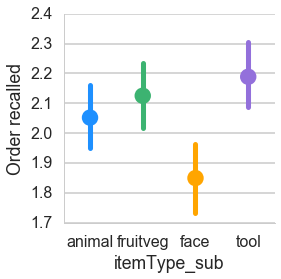

In [62]:
data = dt[(dt.acc == 1) & (dt.run==4)].groupby(['subid', 'itemNum', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='itemType_sub', y='itemNum', 
               dodge=.1,
               units='subid', ci=68, data=data, palette=palette)
plt.ylabel('Order recalled')

plt.savefig('/Volumes/group/awagner/sgagnon/SST/analysis/behav/group_itemtest_orderRecall.png')

In [37]:
%R -i data

ERROR: Line magic function `%R` not found.


In [38]:
%%R 
print(str(data))
df <- within(data, itemType_sub <- relevel(itemType_sub, ref =2))
print(summary(lmer(itemNum ~ itemType_sub + (1 | subid), data=df)))

ERROR: Cell magic `%%R` not found.


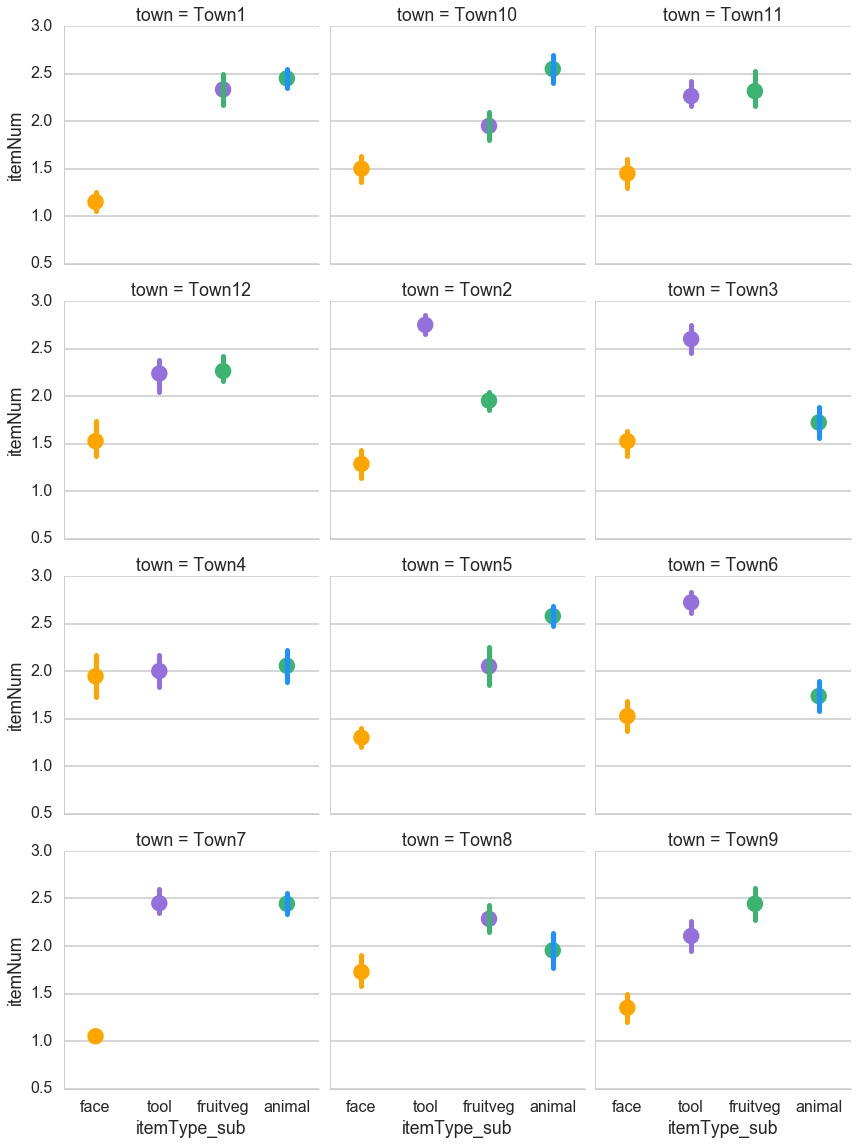

In [63]:
data = dt[(dt.acc == 1) & (dt.run==4)].groupby(['subid', 'town', 'itemNum', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='itemType_sub', y='itemNum', 
               dodge=.1, col='town', col_wrap=3,
               units='subid', ci=68, data=data, palette=palette)

#### Correct recall, across runs

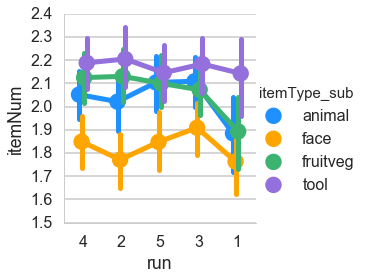

In [64]:
data = dt[(dt.acc == 1)].groupby(['subid', 'itemNum', 'itemType_sub', 'run']).mean().reset_index()
sns.factorplot(x='run', y='itemNum', hue='itemType_sub',
               dodge=.2,
               units='subid', ci=68, data=data,
               palette=palette)

## RTs for correct responses

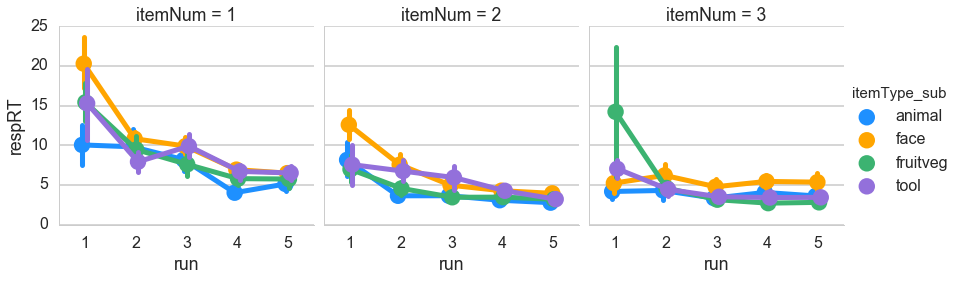

In [69]:
data = dt[dt.acc==1].groupby(['subid', 'run', 'itemType_sub', 'itemNum']).mean().reset_index()
sns.factorplot(x='run', y='respRT', hue='itemType_sub',
               col='itemNum', order=[1,2,3,4,5],
               units='subid', ci=68,
               dodge=.1,
               data=data,
               palette=palette)

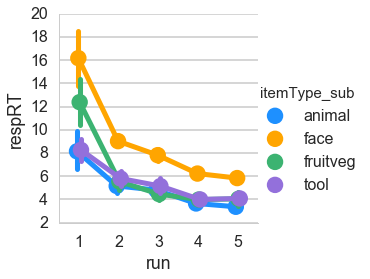

In [68]:
data = dt[dt.acc==1].groupby(['subid', 'run', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='run', y='respRT', hue='itemType_sub',
               units='subid', ci=68, order=[1,2,3,4,5],
               dodge=.1,
               data=data,
               palette=palette)

plt.savefig('/Volumes/group/awagner/sgagnon/SST/analysis/behav/group_itemtest_corr_rt.png')